<a href="https://colab.research.google.com/github/melodyyu1112/Machine_learning_416/blob/master/A4_Loan_Safety_with_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - Loan Safety


The LendingClub is a peer-to-peer lending company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default. 

* Use Pandas Dataframes to do feature engineering
* Train a decision tree model to predict the sentiment of product reviews.
* Visualize the decision tree
* Predict the probability of a certain label using the tree
* Investigate how the complexity of the tree affects the results


> Copyright ©2019 Emily Fox and Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Summer Quarter 2019 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [0]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
save_file('https://homes.cs.washington.edu/~hschafer/cse416/a4/lending-club-data.csv', 'lending-club-data.csv')

In [0]:
import warnings

import matplotlib.pyplot as plt # for graphing
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set()

# Investigate Data




In [0]:
loans = pd.read_csv('lending-club-data.csv')

loans['home_ownership'].unique()
loans.groupby(['home_ownership']).sum()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,last_delinq_none,last_record_none,last_major_derog_none
home_ownership,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MORTGAGE,300493269003,349317359960,847407900,842147475,828406905,792828.44,2.574518e+07,4.879102e+09,919649.92,14359.0,63423.0,897837.0,493944.0,667348.0,6624.0,1079252143,3.163165e+06,1625827.0,1464805.96,1463816.71,8.342996e+08,8.207283e+08,7.184663e+08,1.095789e+08,36900.036265,6217437.259,267822.5407,4.380480e+08,226.0,334174.0,59240,1204,59240,10020,425836,255664,35221.2,49724.0,53332.0,58972.0,5313,424847.413445,33448,52904,51341
OTHER,151237263,170643865,1854900,1798825,1384348,2350.98,5.992961e+04,1.179114e+07,2363.32,62.0,273.0,2488.0,612.0,1645.0,6.0,2238543,8.921961e+03,3776.0,0.00,0.00,1.830703e+06,1.401882e+06,1.491758e+06,3.109513e+05,475.044300,27518.400,3410.7718,4.621937e+05,0.0,339.0,179,43,179,41,900,714,111.2,133.0,169.0,173.0,41,1267.581175,96,171,169
OWN,52104091781,60251345453,120860850,120259200,118411695,136603.62,3.762191e+06,6.319568e+08,157661.67,2103.0,9716.0,138939.0,72246.0,101925.0,1004.0,139911177,4.961836e+05,233494.0,208528.25,208289.88,1.168904e+08,1.150297e+08,1.007357e+08,1.503102e+07,8770.324444,1114875.290,60095.1303,6.018972e+07,35.0,54474.0,9943,182,9943,1935,62326,41910,5905.6,8548.0,9053.0,9898.0,1553,82105.080959,5928,8945,8639
RENT,226992721116,263768176980,600439375,597332425,584118298,740513.53,1.906149e+07,3.229168e+09,820352.09,9462.0,46820.0,741275.0,360047.0,510972.0,5050.0,597481877,2.917725e+06,1109195.0,1027563.04,1027129.90,5.808189e+08,5.671469e+08,4.921654e+08,8.304907e+07,44871.152487,5559505.097,276500.3126,2.561680e+08,167.0,266964.0,53245,1239,53245,11154,291976,220693,32020.8,46780.0,48768.0,53019.0,8256,419237.963312,32635,48056,46998


In [0]:
l=loans.head()
l

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,19850101T000000,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.07,5831.78,5000.00,861.07,0.00,0.00,0.00,20150101T000000,171.62,NaN,20150101T000000,0.0,NaN,1,0,Fully Paid,1,0,11,5,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,20111201T000000,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,19990401T000000,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,20130401T000000,119.66,NaN,20130901T000000,0.0,NaN,1,0,Charged Off,1,1,1,4,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,20011101T000000,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.65,3003.65,2400.00,603.65,0.00,0.00,0.00,20140601T000000,649.91,NaN,20150201T000000,0.0,NaN,1,0,Fully Paid,1,0,11,4,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,19960201T000000,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.30,12226.30,10000.00,2209.33,16.97,0.00,0.00,20150101T000000,357.48,NaN,20150101T000000,0.0,NaN,1,0,Fully Paid,1,0,11,4,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,20041101T000000,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.38,5631.38,5000.00,631.38,0.00,0.00,0.00,20150101T000000,161.03,NaN,20150201T000000,0.0,NaN,1,0,Fully Paid,1,0,4,6,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


First, we will quickly look at the columns of the dataset. We won't end up using all of them, but it's still a good idea to look at what's available.

In [0]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

One feature we will use is the "grade" of the loan. We can investigate what this feature, "grade", looks like:

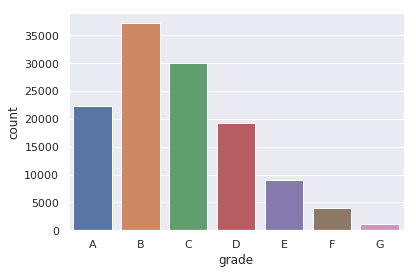

In [0]:
sns.countplot(x='grade', data=loans, order=sorted(loans['grade'].unique()))

We can see that over half of the loan grades are assigned values B or C. Each loan is assigned one of these grades, along with a more finely discretized feature called subgrade (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information if you're interested can be found [here](https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees).

Now let's look at another feature that will be used, "home ownership". This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

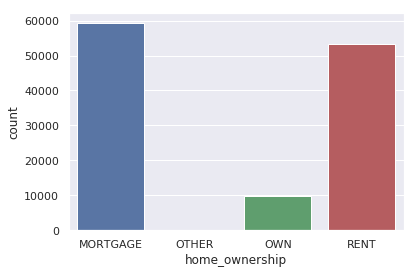

In [0]:
sns.countplot(x='home_ownership', data=loans, order=sorted(loans['home_ownership'].unique()))

## Investigate Data - Target
The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as a safe loan,
* -1 as a risky (bad) loan.

We put this in a new column called `safe_loans`.

In [0]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop(columns='bad_loans')

Now, let's explore the distribution of values for `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset. 

In [0]:
only_safe = loans[loans['safe_loans'] == 1]
only_bad = loans[loans['safe_loans'] == -1]

print(f'Number safe  loans: {len(only_safe)} ({len(only_safe) * 100.0 / len(loans):.2f}%)')
print(f'Number risky loans: {len(only_bad)} ({len(only_bad) * 100.0 / len(loans):.2f}%)')

Number safe  loans: 99457 (81.12%)
Number risky loans: 23150 (18.88%)


## Investigate Data - Questions

<div class="alert alert-block alert-success">
    <h4>Question 1</h4> 
    <p>
        What was the most common loan grade?
    </p>
    <p>
        <b>Gradescope:</b> 
    </p>
    <ul>
  </ul>    <li>B</li>
    
</div>


<div class="alert alert-block alert-success">
    <h4>Question 2</h4> 
    <p>
        How many different types of home ownership are there?
    </p>
    <p>
        <b>Gradescope:</b>
        <ul>
        <li>4</li>
        </ul>
    </p>
</div>

<div class="alert alert-block alert-success">
    <h4>Question 3</h4> 
    <p>
        What's the most frequent target value in the dataset?
    </p>
    <p>
        <b>Gradescope:</b> 
    </p>
    <ul>
        <li>+1 </li>    
    </ul>
</div>

---
# Preprocess Data for Learning
In this section, we pre-process the data to make it suitable for ML.

## Encode Categorical Features
We will be using both numeric and categorical features to predict if a loan is safe or risky. The features are described in code commments in the next cell. 

In [0]:
features = [
    'grade',                     # grade of the loan (e.g. A or B)
    'sub_grade',                 # sub-grade of the loan (e.g. A1, A2, B1)
    'short_emp',                 # one year or less of employment (0 or 1)
    'emp_length_num',            # number of years of employment (a number)
    'home_ownership',            # home_ownership status (one of own, mortgage, rent or other)
    'dti',                       # debt to income ratio (a number)
    'purpose',                   # the purpose of the loan (one of many values)
    'term',                      # the term of the loan (36 months or 60 months)
    'last_delinq_none',          # has borrower had a delinquincy (0 or 1)
    'last_major_derog_none',     # has borrower had 90 day or worse rating (0 or 1)
    'revol_util',                # percent of available credit being used (number between 0 and 100)
    'total_rec_late_fee',        # total late fees received to day (a number)
]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


With how `sklearn` implemented its `DecisionTreeClassifier`, it is only able to handle numerical features; the technical reason being it only allows binary splits and assumes (like other `sklearn` models), that the data is only numerical. This means we need to translate the categorical features into numeric ones. 

The easiest way to do this is a **one-hot encoding** of each categorical feature. Reminder from section last week, a one hot encoding of a feature creates new, derived, features that take on the value 0 or 1 (one new feature for each possible value of the original). For examples, if we had the dataset 

| Gender | HasHouse | Age |
|--------|----------|-----|
| M      | N        | 19  |
| F      | Y        | 23  |
| O      | Y        | 24  |
| F      | N        | 21  |

A one-hot encoding of the categorical features would be 

| Gender_M | Gender_F | Gender_O | HasHouse_N | HasHouse_Y | Age |
|----------|----------|----------|------------|------------|-----|
| 1        | 0        | 0        | 1          | 0          | 19  |
| 0        | 1        | 0        | 0          | 1          | 23  |
| 0        | 0        | 1        | 0          | 1          | 24  |
| 0        | 1        | 0        | 1          | 0          | 21  |


To do this in `pandas`, we use the `get_dummies()` method (another name for one-hot encoding, is dummy variable). We show the new features of the data after running the function in the next cell.

In [0]:
loans = pd.get_dummies(loans)
features = list(loans.columns)
print(features)
loans.head()
#features.remove('safe_loans')
#features

['short_emp', 'emp_length_num', 'dti', 'last_delinq_none', 'last_major_derog_none', 'revol_util', 'total_rec_late_fee', 'safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purch

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0


Here is a preview of the new dataset. Notice our categorical features have become 0/1s represented over many columns (e.g. "grade" becamse "grade_A" through "grade_F").

In [0]:
loans.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0


## Balance Data
You might have noticed from the first section, that there is an imbalance of classes such that the safe loans appear much more frequently than the unsafe loans.  

As we mentioned in class, classification methods tend to have trouble in the cases of class imbalance since you are able to get pretty good classification accurracy just by predicting the majority class. There are multiple ways to combat this problem, but the simplest is to just throw away data in the majority class until the classes are balanced. We do that in the next cell.

In [0]:
safe_loans = loans[loans[target] == +1]
risky_loans = loans[loans[target] == -1]

ratio = len(risky_loans) / len(safe_loans)
print(ratio)
safe_loans = safe_loans.sample(frac=ratio, random_state=1)  # to ensure same results
loans_data = risky_loans.append(safe_loans)

count_safe  = (loans_data[target] == +1).sum() 
count_risky = (loans_data[target] == -1).sum()
print(f'Perfecntage of safe loans : {count_safe / len(loans_data)}')
print(f'Perfecntage of risky loans: {count_risky / len(loans_data)}')
print(f'Total number of loans     : {len(loans_data)}')

0.2327639080205516
Perfecntage of safe loans : 0.5
Perfecntage of risky loans: 0.5
Total number of loans     : 46300


Notice that our new dataset is now in a variable called `loans_data`.

*Note:* There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in [this paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907) (requires access on UW Wi-Fi). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

---
# Model Training
In this section, you will start writing code to train the decision tree model. 

First we split the data into 80% training data and 20% validation data. For this assignment, we will not use a test set since we aren't going to be deploying this model in the future and don't need to make a claim on our accuracy guarantee. 

In [0]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(loans_data, test_size=0.2, random_state=1)

Now let's use `sklearn`'s `DecisionTreeClassifier` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) 
to create a loan-safety prediction model on the training data. 

When creating the model you should only pass in the values `max_depth=6` and `random_state=1` (to make sure we get the same values). Use the features and target defined earlier when training the model on the training data. Save the tree in a variable called `decision_tree_model`.

In [0]:
# TODO train a model with max_depth=6

#from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=1, max_depth=6)
decision_tree_model.fit(train_data[features], train_data[target])


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

Next, we want you to visualize what the tree looks like. In the cell below, we have defined a function to visualize the tree. 

Visualizing a depth 7 tree can be hard, so instead we will train another model stored in a variable called `small_tree_model` that has `max_depth=2`.

Installing Graphviz (especially on Windows) can be kind of tricky. If the code below doesn't run correctly, we provide an image to the picture you should have seen! 

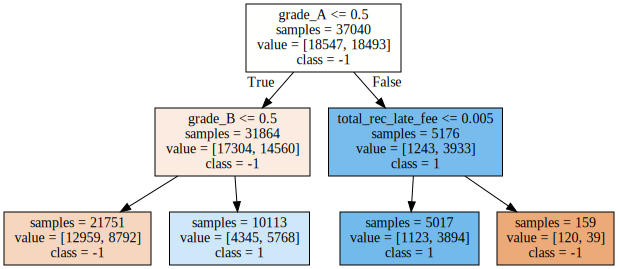

In [0]:
from sklearn import tree

small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=1)
small_tree_model.fit(train_data[features], train_data[target])

# Hack to fail gracefully if graphviz is not installed
try:
    import graphviz

    def draw_tree(tree_model, features):
        """
        visualizes a Decision Tree
        """
        tree_data = tree.export_graphviz(tree_model, 
                                     impurity=False, 
                                     feature_names=features,
                                     class_names=tree_model.classes_.astype(str),
                                     filled=True,
                                     out_file=None)
        graph = graphviz.Source(tree_data) 
        display(graph)
        
    draw_tree(small_tree_model, features)
except:
    print('Graphviz not installed. You can view the picture here! https://courses.cs.washington.edu/courses/cse416/19su/files/assignment-resources/concept/cq4/tree.png')

Each node in the tree shows
* If it's an internal node, show what feature and value it splits on
* `samples`: The number of samples at that node
* `value`: The counts for each label at that node
* `class`: The majority class at that node
* The color showing how confident it is in the predictions at that node (blue is class +1, orange is class -1, white is in between). This corresponds to the probability of it predicting a certain label.

## Making Predictions
Now that we have trained the model, let's look at how it makes predictions on a couple of examples it hasn't seen before from the validation dataset.

In [0]:
sample_validation_data_risky = validation_data[validation_data[target] == -1][0:2]
sample_validation_data_safe = validation_data[validation_data[target] == +1][0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months
83265,0,11,5.92,1,1,19.2,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
89463,0,4,11.49,1,1,61.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
121355,0,11,15.90,1,1,59.7,0.0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
39588,0,11,1.51,0,1,20.4,0.0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Use the `decision_tree_model` to make predictions on the examples in `sample_validation_data` using its `predict` method. Calculate which percentage of those examples it classified correctly. You will likely want to also print the predictions themselves to help with the next problem.

In [0]:
#TODO 
from sklearn.tree import DecisionTreeClassifier
y_true = sample_validation_data[target]
y_pred = decision_tree_model.predict(sample_validation_data[features])
print(sample_validation_data)
print(y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


        short_emp  emp_length_num  ...  term_36 months  term_60 months
83265           0              11  ...               0               1
89463           0               4  ...               1               0
121355          0              11  ...               1               0
39588           0              11  ...               1               0

[4 rows x 68 columns]
[ 1 -1 -1  1]


0.5

<div class="alert alert-block alert-success">
    <h4>Question 4</h4> 
    <p>
        What percentage of the predictions were correct for <code>sample_validation_data</code>?
    </p>
    <p>
        <b>Gradescope:</b> 
    </p>
    <ul>
        <li>50%</li>
    </ul>
</div>

Next, we will have the `decision_tree_model` make predictions and tell us its confidence by using the `predict_proba` method instead that returns the probabilities for each label. 

In the cell below, make predictions with probabilities and identify which load is considered the most likely to be safe.

*Hint:* The probabilities returned will be an array of arrays. To figure out which entry corresponds to "safe", you should look the predictions from the previous question.


In [0]:
# TODO
from sklearn.tree import DecisionTreeClassifier
decision_tree_model.predict_proba(sample_validation_data[features])

array([[0.4591029 , 0.5408971 ],
       [0.50706436, 0.49293564],
       [0.54930305, 0.45069695],
       [0.42893037, 0.57106963]])

<div class="alert alert-block alert-success">
    <h4>Question 5</h4> 
    <p>
        Looking at the output from <code>predict_proba</code>, what is the label predicted for loans with probability &gt; 0.5 in the first column?
    </p>
    <p>
        <b>Gradescope:</b> 
    </p>
    <ul>
        <li>-1</li>
    </ul>
</div>
<div class="alert alert-block alert-success">
    <h4>Question 6</h4> 
    <p>
        Which loan is the most likely to be classified as safe?
    </p>
    <p>
        <b>Gradescope:</b> 
    </p>
    <ul>
        <li>Loan 3</li>
    </ul>
</div>

Now let's turn to the `small_tree_model` and have it make probability predictions for `sample_validation_data`. 

In [0]:
# TODO
from sklearn.tree import DecisionTreeClassifier
y_small_tree_true = sample_validation_data[target]
y_small_tree_pred = small_tree_model.predict(sample_validation_data[features])
print(sample_validation_data)
print(small_tree_model)
print(y_small_tree_pred)
print(decision_tree_model)
from sklearn.metrics import accuracy_score
accuracy_score(y_small_tree_true, y_small_tree_pred)
small_tree_model.predict_proba(sample_validation_data[features])



        short_emp  emp_length_num  ...  term_36 months  term_60 months
83265           0              11  ...               0               1
89463           0               4  ...               1               0
121355          0              11  ...               1               0
39588           0              11  ...               1               0

[4 rows x 68 columns]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')
[ 1 -1 -1 -1]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None

array([[0.42964501, 0.57035499],
       [0.5957887 , 0.4042113 ],
       [0.5957887 , 0.4042113 ],
       [0.5957887 , 0.4042113 ]])

You should see that the last 3 examples all have the exact same probability for being predicted safe. The next question asks you to explain why that is the case.

<div class="alert alert-block alert-success">
    <h4>Question 7</h4> 
    <p>
        Why are the probabilities for being safe the exact same for the last 3 loans in <code>small_tree_model</code>? Write your answer in a one or two sentences.
    </p>
    <p>
        <b>Gradescope:</b> 
          <ul>
        <li>The tree splits with the depth 2 (Grade A and Grade B). The last 3 loans have the same number for Grade A and B, so the probability is the same.</li>
    </ul>
</div>

## Evaluating Accuracy of Model

Recall that the accuracy of a classifier is 

$$accuracy = \frac{\text{# correctly classified examples}}{\text{# total examples}}$$

For `sklearn`, we generally use `sklearn.metrics.accuracy_score` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) to instead of having to write out the formula itself.

First, calculate the training accuracy and the validation accuracy for the `small_tree_model`.

In [0]:
# TODO
from sklearn.metrics import accuracy_score

y_train = train_data[target]
y_train_pred = small_tree_model.predict(train_data[features])
print(accuracy_score(y_train, y_train_pred))

from sklearn.metrics import accuracy_score
y_smallvalid = validation_data[target]
y_smallvalid_pred = small_tree_model.predict(validation_data[features])
accuracy_score(y_smallvalid, y_smallvalid_pred)


0.6139578833693304


0.6171706263498921

<div class="alert alert-block alert-success">
    <h4>Question 8</h4> 
    <p>
        What is the accuracy of the <code>small_tree_model</code> on the <b>validation</b> data?
    </p>
    <p>
        <b>Gradescope:</b> 
    <ul>
    <li>0.62</li>
    </ul> 
    </p>
</div>

In the cell below, compute the train and validation accuracy for the `decision_tree_model`.

In [0]:
# TODO
from sklearn.metrics import accuracy_score
y_valid = validation_data[target]
y_valid_pred = decision_tree_model.predict(validation_data[features])
accuracy_score(y_valid, y_valid_pred)

0.6317494600431965

<div class="alert alert-block alert-success">
    <h4>Question 9</h4> 
    <p>
        What is the accuracy of the <code>decision_tree_model</code> on the <b>validation</b> data?
    </p>
    <p>
    <ul>
    <li>0.63</li>
    </ul>
   
</div>

Next, you should train another decision tree model with `max_depth=10` (remember to also pass in `random_state=1`!). This will make a much deeper tree. 

In the cell below, train the model on the training data and report its training and validation accuracy. Save the model in a variable called `big_tree_model`. Answer the questions below.

In [0]:
# TODO train a model with max_depth=10
big_tree_model = DecisionTreeClassifier(random_state=1, max_depth=10)
big_tree_model.fit(train_data[features], train_data[target])


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [0]:
# TODO assess the training and validation accuracy of that model]
y_train = train_data[target]
y_pred = big_tree_model.predict(train_data[features])
y_big_tree_true = validation_data[target]
y_big_tree_pred = big_tree_model.predict(validation_data[features])
from sklearn.metrics import accuracy_score
print(accuracy_score(y_big_tree_true, y_big_tree_pred))
print(accuracy_score(y_train, y_pred))


0.625377969762419
0.660988120950324


<div class="alert alert-block alert-success">
    <h4>Question 10</h4> 
    <p>
        How does the validation accuracy of the <code>big_tree_model</code> compare to the accuracy of the <code>decision_tree_model</code>? 
    </p>
    <p>
        <b>Gradescope:</b> Select one option.
    </p>
    <ul>
        <li>It is less accurate.</li>
    </ul>
</div>

<div class="alert alert-block alert-success">
    <h4>Question 11</h4> 
    <p>
        What might this, along with the difference in training set accuracy, suggest about whether or not the <code>big_tree_model</code> is overfitting? 
    </p>
    <p>
        <b>Gradescope:</b> Select <b>all</b> options that apply.
    </p>
    <ul>
        <li>The big model is underfit</li>
        <li><b>The big model is overfit</b></li>
        <li>The big model is not deep enough to generalize well.</li>
        <li><b>The big model is too deep.</b></li>
        <li><b>The big model will likely not generalize to unseen data as well as <code>decision_tree_model</code>.</b></li>
    </ul>
</div>

---
# Finding Right Fit
As we saw in the previous example, if we aren't careful with how we set `max_depth`, our model can potentially overfit or underfit. 

A common way of limiting the depth of the tree is to consider two early stopping rules:
* When when the tree reaches a maximum depth (`max_depth`)
* When the leaf nodes have too few data samples in them (`min_samples_leaf`)

Instead of writing the standard hyper-parameter tuning loop you've written before (i.e. loop over possible choices of something like $\lambda$, train on the training data with that value of $\lambda$, and validate using a validation set), we will use a `sklearn` module that does this for us using k-fold cross validation.

The reason we want to use a library for this task is it gets more complicated when we want to find the best combination of both `max_depth` and `min_samples_leaf`. The code becomes quite tedious to write since your loop would need to try all pairs of values for `max_depth` and `min_samples_leaf` and have some way of storing the results to compare.

Instead, we use use `sklearn`'s `GridSearchCV` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) to do all this book-keeping for us! You should look at the documentation on that page (there is a good example underneath the method reference) to solve the following step.

Use `GridSearchCV` to try all combinations of 
* `min_samples_leaf`: [1, 10, 50, 100, 200, 300]
* `max_depth`: [1, 5, 10, 15, 20]

Some implementation details:
* For our code later, save the `GridSearchCV` object in a variable called `search` and the dictionary specifying parameters in a variable called `hyperparameters`.
* You should use 6-fold valudation `cv=6` and make sure it records the training accuracies by using `return_train_score=True`.
* Print the result using the `best_params_` property on the `GridSearchCV` object. 
* This might take a minute or two to run! 

In [0]:
# TODO
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier(random_state=1, max_depth=10)

hyperparameters = {'min_samples_leaf':[1, 10, 50, 100, 200, 300], 'max_depth':[1, 5, 10, 15, 20]}
search = GridSearchCV(model,hyperparameters, cv=6, return_train_score=True)
search.fit(train_data[features], train_data[target])
print(search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 100}


<div class="alert alert-block alert-success">
    <h4>Question 12</h4> 
    <p>
        Which settings of the hyper-parameters were chosen in the grid search?
    </p>
    <p>
        <b>Gradescope:</b>
    </p>
    <code>min_samples_leaf</code>
    <ul>
        <li>1</li>
        <li>10</li>
        <li><b>50</b></li>
        <li>100</li>
        <li>200</li>
        <li>300</li>
    </ul>
    <code>max_depth</code>
    <ul>
        <li>1</li>
        <li><b>5</b></li>
        <li>10</li>
        <li>15</li>
        <li>20</li>
    </ul>
</div>

We can also plot the train and validation accuracy of the models for different settings of the hyper-parameters. The plot will be in 3D since there are 2 inputs for each model specification.

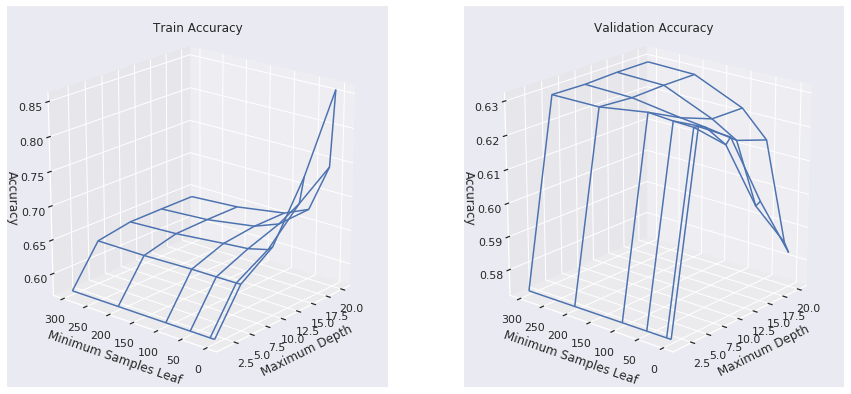

In [0]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

There is no question for this part, but make sure you understand why we see the trends we do here. Make sure you can answer the following questions:
* Why does the train accuracy spike up in the left graph, but go downward on the right graph?
* Which graph should we look at to pick the model that will hopefully do best in the future?
* Why is the spike in training accuracy only for the point with `max_depth=20` and `min_samples_leaf=1`? Why isn't the training accuracy very high for the other settings of `min_samples_leaf` even when `max_depth=20`?

--- 
# Random Forest
In class, we talked about the random forest ensemble. To show us empirically that such a simple idea of adding multiple classifiers works in practice, in this section we are going to implement a type of random forest and analyze its performance. 

Below, we have written the starter code for a class called `RandomForest416` that has methods similar to most sklearn models. You only have to implement the `fit` method, all other parts are implemented for you. However, you should understand how the other code works to help you identify what you need to do.

The `fit` method should train each tree on a different random sample of the examples in the given dataset with $n$ examples. Each random sample should select examples uniformly at random (with replacement) to make a new, modified, dataset of $n$ examples for that tree. To do this, you will want to use `np.random.randint` (documentation [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html#numpy.random.randint)) to generate a random sequence of indices, and then use the `iloc` property on the given `pandas` objects to select those rows. 


In [0]:
import scipy.stats 

class RandomForest416: 
    """
    This class implements the common sklearn model interface (has a fit and predict function).
    
    A random forest is a collection of decision trees that are trained on random subsets of the 
    dataset. When predicting the value for an example, takes a majority vote from the trees.
    """
    
    def __init__(self, num_trees, max_depth=None):
        """
        Constructs a RandomForest416 that uses the given numbner of trees, each with a 
        max depth of max_depth.
        """
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth) 
            for i in range(num_trees)
        ]
        
    def fit(self, X, y):
        """
        Takes an input dataset X and a series of targets y and trains the RandomForest416.
        
        Each tree will be trained on a random sample of the data that samples the examples
        uniformly at random (with replacement). Each random dataset will have the same number
        of examples as the original dataset, but some examples may be missing or appear more 
        than once due to the random sampling with replacement.
        """    
        # TODO implement this method!
        #for tree in self._trees:  
          #index = np.random.randint(len(X), size=len(X))
          #df=X.iloc[index]
          #y= y.iloc[index]
          #tree.fit(df, y) 
        for t in self._trees:
            r_index = np.random.randint(len(X), size=len(X))
            t.fit(X.iloc[r_index], y.iloc[r_index])
    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)
            
            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds
            
        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1)[0]

You can test out your implemenation by running the following cell:

In [0]:
rf = RandomForest416(2, max_depth=1)
rf.fit(sample_validation_data[features], sample_validation_data[target])
rf.predict(sample_validation_data[features])

array([[-1.],
       [-1.],
       [-1.],
       [-1.]])

We can then compare how `sklearn`'s `DecisionTreeClassifier` to our `RandomForest416` to see how its training and validation accuracies compare as a function of the depth of the trees. The code below trains each model with a different max depth and then plots their accuracies. It might take a minute or two to run, but it also prints the progress by showing the current depth it is on (it will range from 1 to 25).

Depth 1
Depth 3
Depth 5
Depth 7
Depth 9
Depth 11
Depth 13
Depth 15
Depth 17
Depth 19
Depth 21
Depth 23
Depth 25


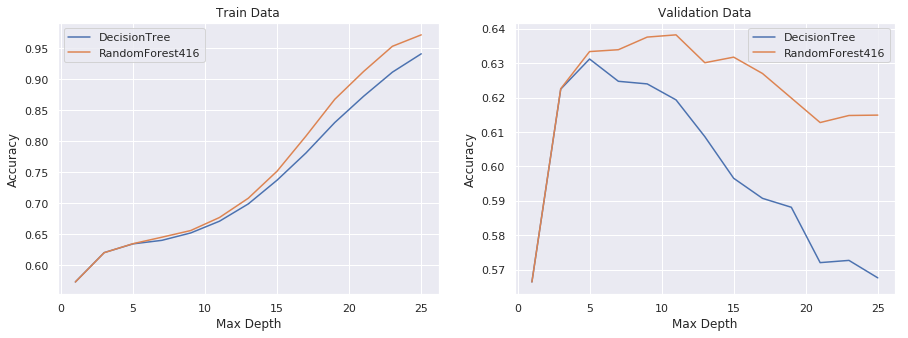

In [0]:
# First calculate the accuracies for each depth
depths = list(range(1, 26, 2))
dt_accuracies = []
rf_accuracies = []

for i in depths:
    print(f'Depth {i}')
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train_data[features], train_data[target])

    dt_accuracies.append((
        accuracy_score(tree.predict(train_data[features]), train_data[target]),
        accuracy_score(tree.predict(validation_data[features]), validation_data[target])
    ))
    
    
    rf = RandomForest416(15, max_depth=i)
    rf.fit(train_data[features], train_data[target])
    
    rf_accuracies.append((     
        accuracy_score(rf.predict(train_data[features]), train_data[target]),
        accuracy_score(rf.predict(validation_data[features]), validation_data[target])
    ))
    
# Then plot them 
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='DecisionTree')
axs[0].plot(depths, [acc[0] for acc in rf_accuracies], label='RandomForest416')

axs[1].plot(depths, [acc[1] for acc in dt_accuracies], label='DecisionTree')
axs[1].plot(depths, [acc[1] for acc in rf_accuracies], label='RandomForest416')

# Customize plots
axs[0].set_title('Train Data')
axs[1].set_title('Validation Data')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')

<div class="alert alert-block alert-success">
    <h4>Question 13</h4> 
    <p>
        Which model, when using max depth of 25, would we expect to perform the best in the future?
    </p>
    <p>
        <b>Gradescope:</b> Select one option.
    </p>
    <ul>
        <li><code>DecistionTreeClassifier</code></li>
        <li><code><b>RandomForest416</code></b></li>
    </ul>
</div>